# Exercise 1. A multilayer perceptron network

## Learning goals

The goal of this exercise is to get familiar with the basics of PyTorch and train a simple feedforward network on a real-world data set. If you are not familiar with PyTorch, there is a number of good tutorials [here](https://pytorch.org/tutorials/index.html). We recommend the following ones:
* [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
* [Autograd: Automatic Differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
* [Learning PyTorch with Examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
* [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

This exercise consists of several tasks which require some background knowledge of basic ML models.

In [95]:
skip_training = True  # Set this flag to True before validation and submission

In [96]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [97]:
# Select data directory
import os
if os.path.isdir('/coursedata'):
    course_data_dir = '/coursedata'
elif os.path.isdir('../data'):
    course_data_dir = '../data'
else:
    # Specify course_data_dir on your machine
    # course_data_dir = ...
    # YOUR CODE HERE
    raise NotImplementedError()

print('The data directory is %s' % course_data_dir)

The data directory is ../data


In [98]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [99]:
# Select device which you are going to use for training
device = torch.device("cpu")

In [100]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

We are going to use *winequality* dataset which contains red and white vinho verde wine samples rated by experts from 0 to 10 (obtained from [here](https://archive.ics.uci.edu/ml/datasets/wine+quality)). We will transform the task into a binary classification problem and try to predict if the quality of wine is greater or lower than 7. The idea is to compare the quality of predictions obtained by a random forest classfier and a simple neural network.

Let us load the data and split it into the training and test sets.

In [101]:
data_dir = os.path.join(course_data_dir, 'winequality')
print('Data loaded from %s' % data_dir)

df = pd.concat([
    pd.read_csv(os.path.join(data_dir, 'winequality-red.csv'), delimiter=';'),
    pd.read_csv(os.path.join(data_dir, 'winequality-white.csv'), delimiter=';')
])

x = df.loc[:, df.columns != 'quality'].values
y = df['quality'].values >= 7  # Convert to a binary classification problem

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, shuffle=True)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

Data loaded from ../data\winequality


## Train a Random forest classifier

*In the code below, train a random forest classifier from sklearn (look at the description [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)) using `x_train` and `y_train` with 100 trees. Name your classifier object `classifier`.*

In [102]:
from sklearn.ensemble import RandomForestClassifier 

classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Accuracy of random forest: 0.88

Classification report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1064
           1       0.74      0.55      0.63       236

   micro avg       0.88      0.88      0.88      1300
   macro avg       0.82      0.75      0.78      1300
weighted avg       0.88      0.88      0.88      1300



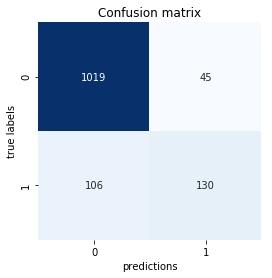

In [103]:
# Compute the accuracy of the random forest classifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

pred_test = classifier.predict(x_test)  # Predict labels of test data using the trained classifier
c_matrix = confusion_matrix(y_test, pred_test) 

rf_accuracy = accuracy_score(y_test, pred_test)
print("Accuracy of random forest: {:.2f}".format(rf_accuracy))
print("\nClassification report:")
print(classification_report(y_test, pred_test))

fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')

As you can see, the random forest classifier works quite nicely in this task without much tuning.

## A multilayer perceptron (MLP) network with two hidden layers

In the code below, define a neural network architecture with:
- input dimensionality 11
- one hidden layer with 100 units with ReLU nonlinearity
- one hidden layer with 100 units with ReLU nonlinearity
- linear output layer with output dimensionality 2.

**Please do not use [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential) in your code.**

You may want to look at [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py) for reference.

In [104]:
n_inputs = 11

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(11, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [105]:
# Let us create the network and make sure it can process a random input of the right shape
mlp = MLP()
y = mlp(torch.randn(10, n_inputs))
assert y.shape == torch.Size([10, 2]), "Bad shape of y: y.shape={}".format(y.shape)

One can also create an instance of a simple deep network using [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential).

In the cell below, please use [`torch.nn.Sequential`](https://pytorch.org/docs/stable/nn.html#torch.nn.Sequential)
to create an MLP with the same structure as above.

In [106]:
# This function should return an MLP model created with torch.nn.Sequential
# - input dimensionality 11
# - one hidden layer with 100 units with ReLU nonlinearity
# - one hidden layer with 100 units with ReLU nonlinearity
# - linear output layer with output dimensionality 2.
mlp_seq = nn.Sequential(nn.Linear(11, 100),
                        nn.ReLU(),
                        nn.Linear(100, 100),
                        nn.ReLU(),
                        nn.Linear(100,2)
                       )

In [107]:
# Print the network
print(mlp_seq)

Sequential(
  (0): Linear(in_features=11, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=2, bias=True)
)


In [108]:
# Let us feed a random input of the right shape to the network created with torch.nn.Sequential.
y = mlp_seq(torch.randn(10, n_inputs))
assert y.shape == torch.Size([10, 2]), "Bad shape of y: y.shape={}".format(y.shape)

## Train an MLP network

Next we will train the multilayer perceptron network. For better understanding of the training process you can take a look at [this part of the tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#backprop).

### Data scaling

Even though deep learning is supposed to work well on raw data without much feature engineering, it is usually a good idea to pre-process data so that the inputs have zero mean and unit standard deviation. PyTorch has its own tools for preprocessing but let us use sklearn's `StandardScaler` for now.

In [109]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

### Training loop

Let us implement the training loop. We will use the Adam optimizer with learning rate 0.01 and we will process the data in the full-batch model (without splitting the data into mini-batches).

*Your task is to insert the missing code. You may find it useful to look at [this tutorial](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).*
Your should have the following steps:
* Transform `x_train_scaled` and `y_train` to `torch.tensor`, make sure the tensors have proper types and they go to the specified `device`.
* Set all gradient values to zeros.
* Calculate outputs of the MLP network (call them `outputs`).
* Calculate cross entropy loss using [`torch.nn.functional.cross_entropy`](https://pytorch.org/docs/stable/nn.html#torch.nn.functional.cross_entropy).
* Backpropagate the loss: compute the gradients of the loss wrt to all the parameters of the MLP.
* Update the parameters of the model using the `optimizer`.

In [128]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.005)
n_epochs = 1000

train_accuracy_history = []
test_accuracy_history = []

for epoch in range(n_epochs):
    # - You need to specify dtype when converting data to torch.tensor
    # - Call the outputs of the model "outputs" like in the line below
    
    # YOUR CODE HERE
    x_train_scaled = torch.as_tensor(x_train_scaled, dtype=torch.float, device=device)
    y_train = torch.as_tensor(y_train, dtype=torch.float, device=device)
    y_train = y_train.long()
    
    mlp.zero_grad()
    outputs =  mlp.forward(x_train_scaled)
    loss = F.cross_entropy(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if skip_training:
        break

    if (epoch % 1) == 0:
        # Store the progress of training
        with torch.no_grad():
            # outputs is the output of the model produced with forward function
            logits = outputs.cpu().data.numpy()
            pred_train = logits.argmax(axis=1)
            train_accuracy = accuracy_score(pred_train, y_train)

            # Compute test error
            x = torch.tensor(x_test_scaled, device=device, dtype=torch.float)
            outputs = mlp.forward(x)
            logits = outputs.cpu().data.numpy()
            pred_test = logits.argmax(axis=1)
            test_accuracy = accuracy_score(pred_test, y_test)
            train_accuracy_history.append(train_accuracy)
            test_accuracy_history.append(test_accuracy)
            if (epoch % 20) == 0:
                print('Train Epoch {}: Loss: {:.6f} Train accuracy {:.2f} Test accuracy {:.2f}'.format(
                    epoch, loss.item(), train_accuracy, test_accuracy))

Train Epoch 0: Loss: 0.779184 Train accuracy 0.21 Test accuracy 0.82
Train Epoch 20: Loss: 0.391460 Train accuracy 0.83 Test accuracy 0.84
Train Epoch 40: Loss: 0.363318 Train accuracy 0.83 Test accuracy 0.82
Train Epoch 60: Loss: 0.342309 Train accuracy 0.83 Test accuracy 0.83
Train Epoch 80: Loss: 0.319339 Train accuracy 0.85 Test accuracy 0.84
Train Epoch 100: Loss: 0.293963 Train accuracy 0.86 Test accuracy 0.85
Train Epoch 120: Loss: 0.268050 Train accuracy 0.88 Test accuracy 0.85
Train Epoch 140: Loss: 0.249995 Train accuracy 0.89 Test accuracy 0.85
Train Epoch 160: Loss: 0.229151 Train accuracy 0.90 Test accuracy 0.85


KeyboardInterrupt: 

The accuracy should be comparable to the accuracy of the random forest classifier.

In [125]:
# Save the network to a file, submit this file together with your notebook
filename = '1_mlp.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(mlp.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    mlp = MLP()
    mlp.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    print('Model loaded from %s' % filename)
    mlp = mlp.to(device)
    mlp.eval()

Do you want to save the model (type yes to confirm)? yes
Model saved to 1_mlp.pth


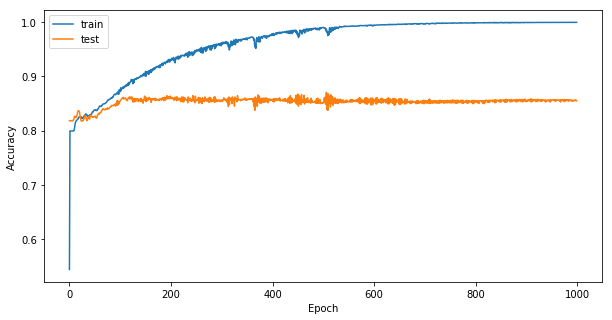

In [126]:
# Let us plot the accuracies during training
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.plot(train_accuracy_history, label='train')
ax.plot(test_accuracy_history, label='test')
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.legend()


Classification report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1064
           1       0.59      0.65      0.62       236

   micro avg       0.86      0.86      0.86      1300
   macro avg       0.76      0.78      0.77      1300
weighted avg       0.86      0.86      0.86      1300



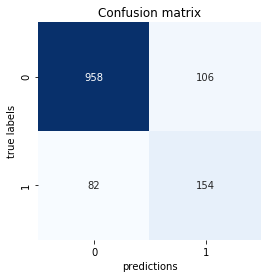

In [127]:
# Let's print the classification report and plot the confusion matrix similarly to the random forest classifier.
print("\nClassification report:")
print(classification_report(y_test, pred_test))

c_matrix = confusion_matrix(y_test, pred_test)
fig, ax = plt.subplots(1, figsize=(4, 4))
ax.set_title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, fmt='g', cbar=False)
ax.set_xlabel('predictions')
ax.set_ylabel('true labels')

Note that even though the random forest classifier may have better performance, the performance of the MLP network may be improved by tuning the hyperparameters, such as:
* number of hidden units
* number of layers
* learning rate schedule
* regularization methods.

The message from this exercise is that in simple problems that do not have spatial (like in images) or temporal (like in time series) structure, alternative classifiers (like random forests) may do very well.

## Define an MLP with an arbitrary number of layers

Let us now define a multilayer perceptron with an arbitrary number of layers and arbitrary number of neurons in each layer, so that an MLP can be created as follows:
```python
> mlp = FancyMLP([11, 150, 100, 50, 2], activation_fn=F.tanh)
```
In the example above, we created a network with three hidden layers: 150 units in the first hidden layer, 100 units in the second one and 50 units in the third one.

Note: The same activation function should be applied to all the layers except for the last one. This way the MLP can be used either for regression or classification.

Hints:
* You may find it useful to use function [`torch.nn.Module.add_module`](https://pytorch.org/docs/master/nn.html#torch.nn.Module.add_module) or class [`torch.nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#torch.nn.ModuleList).
* Check how many trainable parameters a created MLP has.

In [ ]:
class FancyMLP(nn.Module):
    def __init__(self, sizes, activation_fn=torch.tanh):
        """Multilayer perceptron with an arbitrary number of layers.
        
        Args:
          sizes (list):             Number of units in each layer including the input and the output layer:
                                    [n_inputs, n_units_in_hidden_layer1, ..., n_units_in_hidden_layerN, n_outputs]
          activation_fn (callable): An element-wise function used in every layer except in the last one.
        """
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
# Let us now test your class
mlp = FancyMLP([n_inputs, 100, 50, 2])
y = mlp(torch.randn(10, n_inputs))
assert y.shape == torch.Size([10, 2]), "Bad shape of y: y.shape={}".format(y.shape)

mlp = FancyMLP([3, 10, 30, 40, 50, 5])
y = mlp(torch.randn(10, 3))
assert y.shape == torch.Size([10, 5]), "Bad shape of y: y.shape={}".format(y.shape)

In [ ]:
# Print the MLP
mlp